In [72]:
from typing import NamedTuple, List
import random
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt

In [73]:
class Parameters(NamedTuple):
    max_generations: int
    population_size: int
    coefficient_range: tuple
    polynomial_degree: int
    carry_on_probability: float
    crossover_probability: float
    mutation_probability: float
    flip_probability: float

In [74]:
class Chromosome:
    def __init__(self, coefficient = None, rand = False, parameters = None):
        self.coefficients: List[int] = []
        if rand is not True and coefficient is None:
            raise ValueError("can't generate chromosome")
        if coefficient is not None:
            self.coefficients: List[int] = coefficient
            self.degree: int = len(coefficient)
        else:
            for i in range(0, parameters.polynomial_degree + 1):
                self.coefficients.append(random.uniform(parameters.coefficient_range[0], parameters.coefficient_range[1]))
            while self.coefficients[0] == 0:
                self.coefficients[0] = random.uniform(parameters.coefficient_range[0], parameters.coefficient_range[1])
        self.fitness: int = 0
        
    def evaluate_polynomial(self, x):
        return np.polyval(self.coefficients, x)
    
    def calc_fitness(self, trainingData):
        predicted = self.evaluate_polynomial([point[0] for point in trainingData])
        self.fitness = 1 / (1 + sum([abs(predicted[i] - trainingData[i][1]) for i in range(len(trainingData))]))
        return self.fitness

In [75]:
class Polynomial:
    def __init__(self, parameters: Parameters, trainingData: List[tuple]):
        self.parameters = parameters
        self.trainingData = trainingData
        self.population: List[Chromosome] = []
        self.best_chromosome: Chromosome = None
        self.best_fitness: int = 0
        self.avg_fitness: int = 0
        self.generation: int = 0
        self.generate_population()
        
    def generate_population(self):
        for i in range(self.parameters.population_size):
            self.population.append(Chromosome(rand = True, parameters = self.parameters))
        self.evaluate_population()
        
    def evaluate_population(self):
        self.best_fitness = 0
        self.avg_fitness = 0
        for chromosome in self.population:
            fitness = chromosome.calc_fitness(self.trainingData)
            self.avg_fitness += fitness
            if fitness > self.best_fitness:
                self.best_fitness = fitness
                self.best_chromosome = chromosome
        self.avg_fitness /= self.parameters.population_size
        
    def carry_on(self):
        new_population = []
        for chromosome in self.population:
            if random.random() < self.parameters.carry_on_probability:
                new_population.append(chromosome)
        self.population = new_population
        
    def crossover(self):
        new_population = []
        while len(new_population) < self.parameters.population_size:
            parent1 = random.choice(self.population)
            parent2 = random.choice(self.population)
            if random.random() < self.parameters.crossover_probability:
                crossover_point = random.randint(1, self.parameters.polynomial_degree)
                child1 = Chromosome(coefficient = parent1.coefficients[:crossover_point] + parent2.coefficients[crossover_point:])
                child2 = Chromosome(coefficient = parent2.coefficients[:crossover_point] + parent1.coefficients[crossover_point:])
                new_population.append(child1)
                new_population.append(child2)
        self.population = new_population
        
    def mutate(self):
        for chromosome in self.population:
            if random.random() < self.parameters.mutation_probability:
                for i in range(self.parameters.polynomial_degree + 1):
                    if random.random() < self.parameters.flip_probability:
                        chromosome.coefficients[i] = random.uniform(self.parameters.coefficient_range[0], self.parameters.coefficient_range[1])
                while chromosome.coefficients[0] == 0:
                    chromosome.coefficients[0] = random.uniform(self.parameters.coefficient_range[0], self.parameters.coefficient_range[1])
        
    def evolve(self):
        while self.generation < self.parameters.max_generations and self.best_fitness < 0.99:
            self.generation += 1
            self.carry_on()
            self.crossover()
            self.mutate()
            self.evaluate_population()
            if self.generation % 100 == 0:
                self.print()
            
    def plot(self):
        x = [point[0] for point in self.trainingData]
        y = [point[1] for point in self.trainingData]
        plt.plot(x, y, 'ro')
        x = np.linspace(min(x), max(x), 100)
        y = self.best_chromosome.evaluate_polynomial(x)
        plt.plot(x, y, 'b-')
        plt.title("Polynomial Regression")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(["Training Data", "Best Polynomial"])
        plt.show()
        
    def print(self):
        print("Generation: ", self.generation)
        print("Best fitness: ", self.best_fitness)
        print("Average fitness: ", self.avg_fitness)
        print("Best chromosome: ", self.best_chromosome.coefficients)
        print("-" * 50)

In [76]:
parameters = Parameters(
    max_generations = 2000,
    population_size = 200,
    coefficient_range = (-12, 12),
    polynomial_degree = 7,
    carry_on_probability = 0.1,
    crossover_probability = 0.65,
    mutation_probability = 0.5,
    flip_probability = 0.45
)

trainingData = [(1, 7), (2, 527), (3, 9723), (0, 9), (-1, 11), (-2, -677), (-3, -12153)]

In [77]:
polynomial = Polynomial(parameters, trainingData)
polynomial.evolve()

Generation:  100
Best fitness:  0.00036169393313075914
Average fitness:  3.251656215060338e-05
Best chromosome:  [3.8346098241465096, -1.6483483185939427, 4.435549106973863, -6.276509281875614, 8.706774600435182, 3.5196465270260546, -2.66325967082596, 1.6973435464983773]
--------------------------------------------------
Generation:  200
Best fitness:  0.0010331580888680385
Average fitness:  8.016243737296046e-05
Best chromosome:  [4.726369442075807, -1.3221146541732924, 3.481247281912438, -6.538040700029884, -8.683129627222408, -7.568047570417944, -4.889053634520895, 10.994659191113833]
--------------------------------------------------
Generation:  300
Best fitness:  0.00038273729805842
Average fitness:  3.346892755909944e-05
Best chromosome:  [6.216631612818922, -3.8883250381046004, -6.605368857132634, 8.857571296206213, 8.105041070553806, 4.825679372142865, -4.406269617599862, 7.826637605379123]
--------------------------------------------------
Generation:  400
Best fitness:  0.00

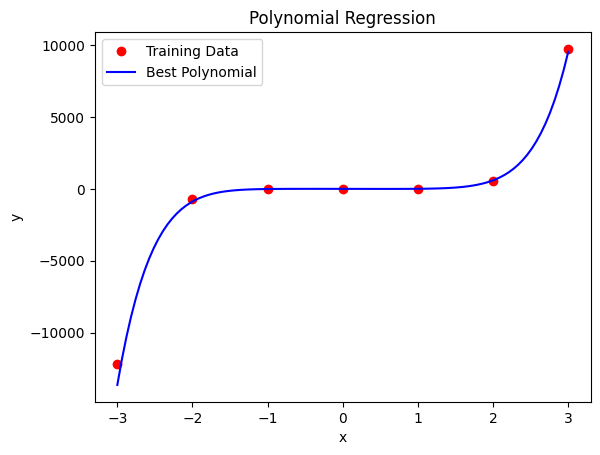

Generation:  2000
Best fitness:  0.0005046219790352534
Average fitness:  4.146640911211456e-05
Best chromosome:  [5.071383492782498, -3.4276186308885173, 1.214057462514969, 6.197783742192993, 7.702870969234862, -5.970123666492583, -6.552784393706673, -1.4767259300731332]
--------------------------------------------------


In [78]:
polynomial.plot()
polynomial.print()